In [ ]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

plt.style.use('seaborn-v0_8')

In [22]:
with open('memecoin_data.json', 'r') as f:
    memecoin_data = json.load(f)

with open('memecoin_tweets.json', 'r') as f:
    tweet_data = json.load(f)

In [23]:
def parse_tweet_date(tweet):
    """Extract date from tweet and convert to datetime"""
    try:
        return pd.to_datetime(tweet['created_at']).date()
    except Exception as e:
        print(f"Error parsing date for tweet: {e}")
        return None

def process_tweets_by_date(coin_data):
    """Group tweets by date and return a dictionary"""
    tweets_by_date = {}
    
    if not coin_data or 'timeline' not in coin_data:
        return tweets_by_date
        
    for tweet in coin_data['timeline']:
        date = parse_tweet_date(tweet)
        if date:
            if date not in tweets_by_date:
                tweets_by_date[date] = []
            tweets_by_date[date].append(tweet)
            
    return tweets_by_date

In [24]:
processed_data = {}
for coin_key, coin_data in tweet_data.items():
    processed_data[coin_key] = process_tweets_by_date(coin_data)

In [51]:
dates = set()
for coin_data in processed_data.values():
    dates.update(coin_data.keys())
dates = sorted(list(dates))

tweet_counts = pd.DataFrame(index=dates, columns=processed_data.keys()).fillna(0)
tweet_df = pd.DataFrame(index=dates, columns=processed_data.keys()).fillna({})

for coin, data in processed_data.items():
    for date, tweets in data.items():
        tweet_counts.at[date, coin] = len(tweets)
        tweet_df.at[date, coin] = json.dumps(tweets)

/var/folders/x6/5wg56fk56psf1y3lsgby72fh0000gn/T/ipykernel_17913/1250085420.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tweet_counts = pd.DataFrame(index=dates, columns=processed_data.keys()).fillna(0)


In [53]:
tweet_df.head()

,dogecoin,shiba-inu,pepe,bonk,dogwifcoin,floki,pudgy-penguins,based-brett,mog-coin,popcat
2021-12-12,NaN,"[{""type"": ""tweet"", ""tweet_id"": ""14700062212562...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-23,NaN,"[{""type"": ""tweet"", ""tweet_id"": ""16610177482423...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-15,NaN,"[{""type"": ""tweet"", ""tweet_id"": ""17249231320776...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-29,NaN,NaN,"[{""type"": ""tweet"", ""tweet_id"": ""17631873704535...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-10,NaN,NaN,NaN,NaN,"[{""type"": ""tweet"", ""tweet_id"": ""17666800475474...",NaN,NaN,NaN,NaN,NaN


In [26]:
price_data = {}
for coin_key, data in memecoin_data.items():
    if 'historical_prices' in data:
        prices_df = pd.DataFrame(data['historical_prices'])
        prices_df['date'] = pd.to_datetime(prices_df['date']).dt.date
        prices_df = prices_df.drop_duplicates(subset=['date'], keep='last')
        price_data[coin_key] = pd.Series(prices_df['price'].values, index=prices_df['date'])

price_df = pd.DataFrame(price_data)


In [27]:
common_dates = tweet_counts.index.intersection(price_df.index)
correlations = {}

for coin in processed_data.keys():
    if coin in price_df.columns:
        tweet_series = tweet_counts.loc[common_dates, coin]
        price_series = price_df.loc[common_dates, coin]
        if len(tweet_series) > 1 and tweet_series.sum() > 0:
            correlation = np.corrcoef(tweet_series, price_series)[0, 1]
            correlations[coin] = correlation


In [28]:
print("\nCorrelation between daily tweet counts and prices:")
for coin, corr in correlations.items():
    print(f"{coin}: {corr:.3f}")


Correlation between daily tweet counts and prices:
dogecoin: -0.790
shiba-inu: -0.634
pepe: -0.591
bonk: -0.688
dogwifcoin: -0.506
floki: -0.779
pudgy-penguins: nan
based-brett: -0.619
mog-coin: -0.562
popcat: -0.645


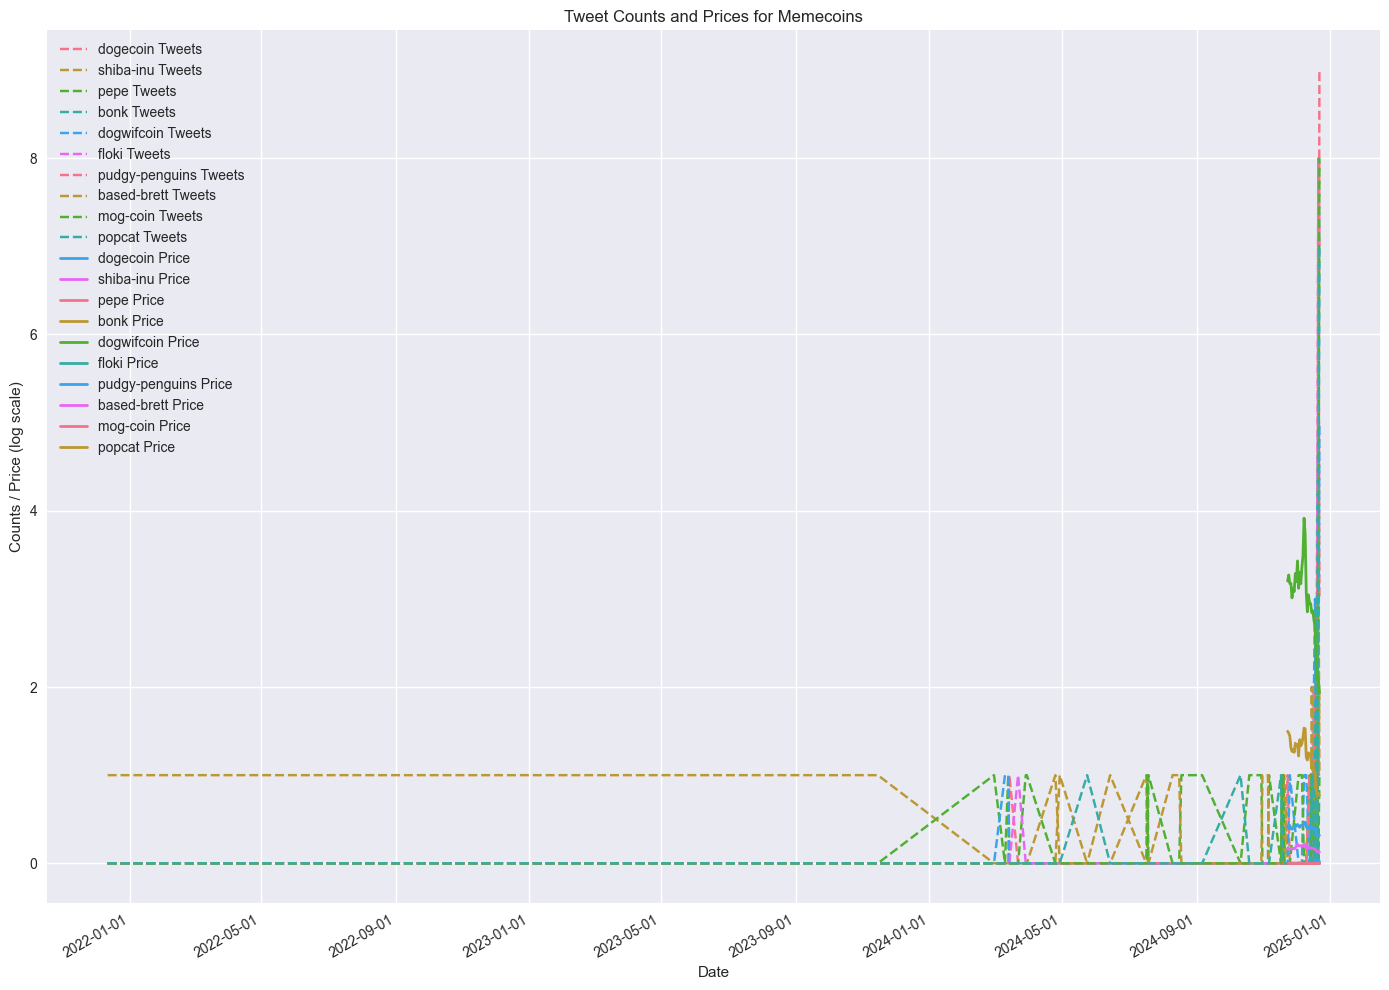

In [34]:
plt.figure(figsize=(14, 10))

# Plot tweet counts for each coin
for coin in tweet_counts.columns:
    if tweet_counts[coin].sum() > 0:  # Only include coins with tweets
        plt.plot(pd.to_datetime(tweet_counts.index), tweet_counts[coin], 
                 label=f'{coin} Tweets', linestyle='--')

# Plot prices for each coin
for coin in price_df.columns:
    plt.plot(pd.to_datetime(price_df.index), price_df[coin], 
             label=f'{coin} Price', linewidth=2)

plt.title('Tweet Counts and Prices for Memecoins')
plt.xlabel('Date')
plt.ylabel('Counts / Price')
plt.legend()
plt.grid(True)

# Improve date formatting
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()